# 관련성 체크 추가

**절차**

1. Naive RAG 수행
2. (이번 튜토리얼) 검색된 문서에 대한 관련성 체크(Groundedness Check) 추가

**참고**

- 이전 튜토리얼에서 확장된 내용이므로, 겹치는 부분이 있을 수 있습니다. 부족한 설명은 이전 튜토리얼을 참고해주세요.

![langgraph-add-relevance-check](assets/langgraph-add-relevance-check.png)

## 환경 설정

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv(override=True)

True

In [2]:
# LangSmith 추적을 설정합니다.
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("LangGraph-RAG")

LangSmith 추적을 시작합니다.
[프로젝트명]
LangGraph-RAG


## 기본 PDF 기반 Retrieval Chain 생성

여기서는 PDF 문서를 기반으로 Retrieval Chain 을 생성합니다. 가장 단순한 구조의 Retrieval Chain 입니다.

단, LangGraph 에서는 Retirever 와 Chain 을 따로 생성합니다. 그래야 각 노드별로 세부 처리를 할 수 있습니다.

**참고**

- 이전 튜토리얼에서 다룬 내용이므로, 자세한 설명은 생략합니다.

In [3]:
from func.docs import MongoEmbeddingRetrievalChain

# PDF 문서를 로드합니다.
mongodb = MongoEmbeddingRetrievalChain().create_chain()

# retriever와 chain을 생성합니다.
retriever = mongodb.retriever
chain = mongodb.chain

## State 정의

`State`: Graph 의 노드와 노드 간 공유하는 상태를 정의합니다.

일반적으로 `TypedDict` 형식을 사용합니다.

이번에는 상태(State)에 관련성(relevance) 체크 결과를 추가합니다.

In [4]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages


# GraphState 상태 정의
class GraphState(TypedDict):
    question: Annotated[str, "Question"]  # 질문
    context: Annotated[str, "Context"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)
    relevance: Annotated[str, "Relevance"]  # 관련성

## 노드(Node) 정의

- `Nodes`: 각 단계를 처리하는 노드입니다. 보통은 Python 함수로 구현합니다. 입력과 출력이 상태(State) 값입니다.
  
**참고**  

- `State`를 입력으로 받아 정의된 로직을 수행한 후 업데이트된 `State`를 반환합니다.

In [10]:
from langchain_openai import ChatOpenAI
from langchain_teddynote.evaluator import GroundednessChecker
from langchain_teddynote.messages import messages_to_history
from func.utils import format_searched_docs


# 문서 검색 노드
def retrieve_document(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = retriever.invoke(latest_question)

    # 검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
    retrieved_docs = format_searched_docs(retrieved_docs)

    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(context=retrieved_docs)


# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 검색된 문서를 상태에서 가져옵니다.
    context = state["context"]

    # 체인을 호출하여 답변을 생성합니다.
    response = chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )

    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    return {
        "answer": response,
        "messages": [("user", latest_question), ("assistant", response)],
    }


# 관련성 체크 노드
def relevance_check(state: GraphState) -> GraphState:
    # 관련성 평가기를 생성합니다.
    question_retrieval_relevant = GroundednessChecker(
        llm=ChatOpenAI(model="gpt-4.1-nano", temperature=0), target="question-retrieval"
    ).create()

    # 관련성 체크를 실행("yes" or "no")
    response = question_retrieval_relevant.invoke(
        {"question": state["question"], "context": state["context"]}
    )

    print("==== [RELEVANCE CHECK] ====")
    print(response.score)

    # 참고: 여기서의 관련성 평가기는 각자의 Prompt 를 사용하여 수정할 수 있습니다. 여러분들의 Groundedness Check 를 만들어 사용해 보세요!
    return {"relevance": response.score}


def is_relevant(state: GraphState) -> GraphState:
    if state["relevance"] == "yes":
        return "relevant"
    else:
        return "not relevant"

## Edges

- `Edges`: 현재 `State`를 기반으로 다음에 실행할 `Node`를 결정하는 Python 함수.

일반 엣지, 조건부 엣지 등이 있습니다.

In [11]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 정의
workflow = StateGraph(GraphState)

# 노드 추가
workflow.add_node("retrieve", retrieve_document)
# 관련성 체크 노드 추가
workflow.add_node("relevance_check", relevance_check)
workflow.add_node("llm_answer", llm_answer)

# 엣지 추가
workflow.add_edge("retrieve", "relevance_check")  # 검색 -> 관련성 체크


# 조건부 엣지를 추가합니다.
workflow.add_conditional_edges(
    "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    is_relevant,
    {
        "relevant": "llm_answer",  # 관련성이 있으면 답변을 생성합니다.
        "not relevant": "retrieve",  # 관련성이 없으면 다시 검색합니다.
    },
)

workflow.add_edge("llm_answer", END)

# 그래프 진입점 설정
workflow.set_entry_point("retrieve")

# 체크포인터 설정
memory = MemorySaver()

# 그래프 컴파일
app = workflow.compile(checkpointer=memory)

컴파일한 그래프를 시각화 합니다.

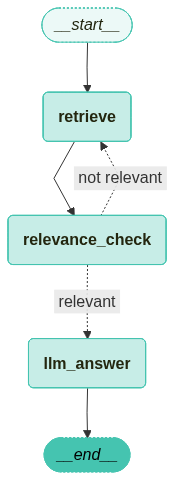

In [12]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

## 그래프 실행

- `config` 파라미터는 그래프 실행 시 필요한 설정 정보를 전달합니다.
- `recursion_limit`: 그래프 실행 시 재귀 최대 횟수를 설정합니다.
- `inputs`: 그래프 실행 시 필요한 입력 정보를 전달합니다.

In [15]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = GraphState(question="newjeans-attention")
# inputs = GraphState(question="word2vec이 뭐야")

# 그래프 실행
invoke_graph(app, inputs, config, ["relevance_check", "llm_answer"])

==== [RELEVANCE CHECK] ====
no

🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
no
==== [RELEVANCE CHECK] ====
no

🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
no
==== [RELEVANCE CHECK] ====
no

🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
no
==== [RELEVANCE CHECK] ====
no

🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
no
==== [RELEVANCE CHECK] ====
no

🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
no
==== [RELEVANCE CHECK] ====
no

🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
no
==== [RELEVANCE CHECK] ====
no

🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
no
==== [RELEVANCE CHECK] ====
no

🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
no
==== [RELEVANCE 

GraphRecursionError: Recursion limit of 20 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [9]:
# 그래프 스트리밍 출력
stream_graph(app, inputs, config, ["relevance_check", "llm_answer"])


🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"score":"yes"}==== [RELEVANCE CHECK] ====
yes

🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
앤스로픽에 투자한 기업과 투자금액은 다음과 같습니다.

- 구글: 최대 20억 달러 투자 합의, 이 중 5억 달러를 우선 투자했으며, 2023년 2월에 이미 5억 5,000만 달러 투자
- 아마존: 최대 40억 달러 투자 계획 공개
- 마이크로소프트: 앤스로픽이 아닌 오픈AI에 30억 달러 투자 후 2023년 1월에 추가 100억 달러 투자

즉, 앤스로픽에 직접 투자한 기업은 구글과 아마존이며, 구글은 총 최대 20억 달러, 아마존은 최대 40억 달러를 투자할 계획입니다.

**Source**
- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 14)

In [10]:
outputs = app.get_state(config).values

print(f'Question: {outputs["question"]}')
print("===" * 20)
print(f'Answer:\n{outputs["answer"]}')

Question: 앤스로픽에 투자한 기업과 투자금액을 알려주세요.
Answer:
앤스로픽에 투자한 기업과 투자금액은 다음과 같습니다.

- 구글: 최대 20억 달러 투자 합의, 이 중 5억 달러를 우선 투자했으며, 2023년 2월에 이미 5억 5,000만 달러 투자
- 아마존: 최대 40억 달러 투자 계획 공개
- 마이크로소프트: 앤스로픽이 아닌 오픈AI에 30억 달러 투자 후 2023년 1월에 추가 100억 달러 투자

즉, 앤스로픽에 직접 투자한 기업은 구글과 아마존이며, 구글은 총 최대 20억 달러, 아마존은 최대 40억 달러를 투자할 계획입니다.

**Source**
- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 14)


In [11]:
print(outputs["relevance"])

yes


하지만, 검색 결과의 `relevance_check` 가 실패할 경우, 반복하여 동일한 Query 가 다시 retrieve 노드로 들어가는 상황이 발생합니다.

반복하여 동일한 Query 가 다시 retrieve 노드로 들어가면, 동일한 검색 결과로 이어지기 때문에, 결국 재귀 상태에 빠지게 됩니다.

혹시 모를 재귀 상태를 방지하기 위해, 재귀 최대 횟수(`recursion_limit`)를 설정합니다. 그리고, 에러 처리를 위하여 `GraphRecursionError` 를 처리합니다.

다음 튜토리얼에서는 이와 같이 재귀상태로 빠지는 문제를 해결하는 방법을 다루겠습니다.

In [12]:
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = GraphState(question="테디노트의 랭체인 튜토리얼에 대한 정보를 알려주세요.")

try:
    # 그래프 실행
    stream_graph(app, inputs, config, ["retrieve", "relevance_check", "llm_answer"])
except GraphRecursionError as recursion_error:
    print(f"GraphRecursionError: {recursion_error}")


🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"score":"==== [RELEVANCE CHECK] ====no
no
"}{"score":"no"}==== [RELEVANCE CHECK] ====
no
{"score":"no"}==== [RELEVANCE CHECK] ====
no
{"score":"no"}==== [RELEVANCE CHECK] ====
no
{"score":"no==== [RELEVANCE CHECK] ====
no
"}GraphRecursionError: Recursion limit of 10 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT


리커젼 반복되면서 에러가 발생하는거 문제해결이 필요함 -> 4번파일에서 해결